In [1]:
#import libraries


import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import tensorflow.keras as keras

from keras import models 
from keras import layers
from keras import optimizers 

from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import warnings
warnings.filterwarnings("ignore", message="`np.object`")


## EDA

In [2]:
# Don't for get to check distribution, check for duplicates, nans
# get statistics if needed/useful 

In [3]:
# Define paths
train_dir = 'chest_xray/train/'
val_dir = 'chest_xray/val/'
test_dir = 'chest_xray/test/'

In [4]:
train_normal_count = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
train_pneumonia_count = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
val_normal_count = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
val_pneumonia_count = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
test_normal_count = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
test_pneumonia_count = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))

print("Train Data:")
print(f"Normal Images: {train_normal_count}")
print(f"Pneumonia Images: {train_pneumonia_count}")

print("\nValidation Data:")
print(f"Normal Images: {val_normal_count}")
print(f"Pneumonia Images: {val_pneumonia_count}")

print("\nTest Data:")
print(f"Normal Images: {test_normal_count}")
print(f"Pneumonia Images: {test_pneumonia_count}")

Train Data:
Normal Images: 1341
Pneumonia Images: 3875

Validation Data:
Normal Images: 8
Pneumonia Images: 8

Test Data:
Normal Images: 234
Pneumonia Images: 390


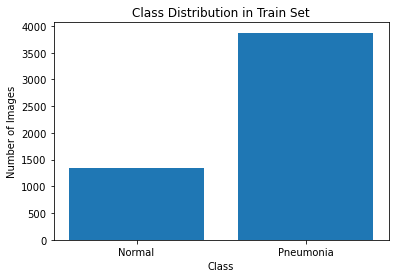

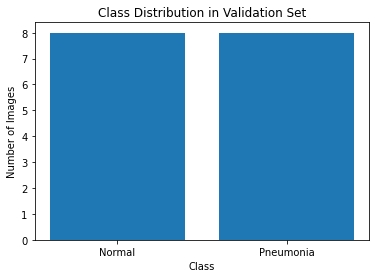

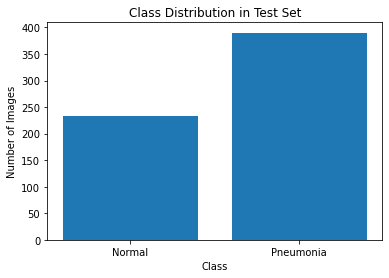

In [5]:
# Function to plot class distribution
def plot_class_distribution(normal_count, pneumonia_count, set_name):
    plt.bar(['Normal', 'Pneumonia'], [normal_count, pneumonia_count])
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title(f'Class Distribution in {set_name} Set')
    plt.show()

# Plot class distribution for each set
plot_class_distribution(train_normal_count, train_pneumonia_count, 'Train')
plot_class_distribution(val_normal_count, val_pneumonia_count, 'Validation')
plot_class_distribution(test_normal_count, test_pneumonia_count, 'Test')

## Designing the Model 

In [6]:
# Preprocess the images into tensors
# Rescale the data by 1/.255 and use binary_crossentropy loss

from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=5216,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                        target_size=(150, 150),
                                                        batch_size=16,
                                                        class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(150, 150),
                                                        batch_size=624,
                                                        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Label: 0.0


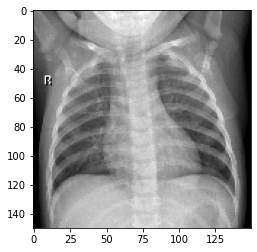

In [8]:
sample_image = train_images[1]
sample_label = train_labels[1]
display(plt.imshow(sample_image))
print('Label: {}'.format(sample_label))

In [9]:
# Get value counts
unique_elements, counts = np.unique(train_labels, return_counts=True)

# Combine the unique elements and their counts into a dictionary
value_counts_dict = dict(zip(unique_elements, counts))

# Print the result
print(value_counts_dict)

{0.0: 1341, 1.0: 3875}


In [10]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 150, 150, 3)
train_labels shape: (5216,)
test_images shape: (624, 150, 150, 3)
test_labels shape: (624,)
val_images shape: (16, 150, 150, 3)
val_labels shape: (16,)


In [11]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 67500)
(624, 67500)
(16, 67500)


In [12]:
train_y = np.reshape(train_labels, (5216,1))
test_y = np.reshape(test_labels, (624,1))
val_y = np.reshape(val_labels, (16,1))

In [13]:
# Build a baseline fully connected model
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(67500,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
163/163 [==============================] - 3s 14ms/step - loss: 0.5131 - accuracy: 0.7558 - val_loss: 2.3998 - val_accuracy: 0.5000
Epoch 2/50
163/163 [==============================] - 2s 13ms/step - loss: 0.3845 - accuracy: 0.8487 - val_loss: 0.4745 - val_accuracy: 0.8750
Epoch 3/50
163/163 [==============================] - 2s 13ms/step - loss: 0.3004 - accuracy: 0.8815 - val_loss: 0.5260 - val_accuracy: 0.8125
Epoch 4/50
163/163 [==============================] - 3s 17ms/step - loss: 0.2552 - accuracy: 0.9059 - val_loss: 0.4236 - val_accuracy: 0.8750
Epoch 5/50
163/163 [==============================] - 2s 12ms/step - loss: 0.2199 - accuracy: 0.9155 - val_loss: 0.7803 - val_accuracy: 0.6250
Epoch 6/50
163/163 [==============================] - 2s 12ms/step - loss: 0.1979 - accuracy: 0.9235 - val_loss: 0.3828 - val_accuracy: 0.8125
Epoch 7/50
163/163 [==============================] - 2s 11ms/step - loss: 0.1799 - accuracy: 0.9316 - val_loss: 0.8798 - val_accuracy: 0.6875

In [15]:
results_train = model.evaluate(train_img, train_y)

163/163 [==============================] - 1s 7ms/step - loss: 0.0745 - accuracy: 0.9739


In [16]:
results_test = model.evaluate(test_img, test_y)

20/20 [==============================] - 1s 17ms/step - loss: 0.8845 - accuracy: 0.7692


In [17]:
print('Train Results:', results_train)
print('Test Results:', results_test)

Train Results: [0.07452423125505447, 0.9739263653755188]
Test Results: [0.8845446705818176, 0.7692307829856873]


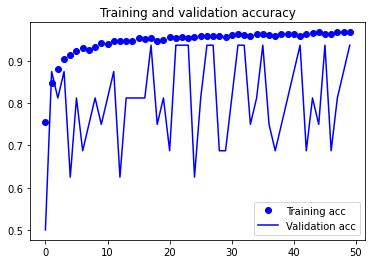

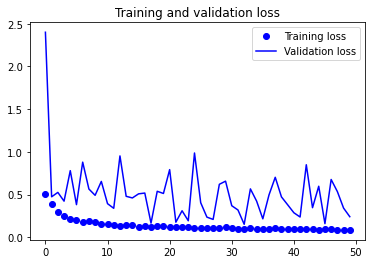

In [18]:
# Plot history

import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Baseline model seemed to show some degree of overfitting. 
- Train Accuracy: 0.97
- Test Accuracy: 0.77

## Building a CNN

In [19]:
# Design the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [20]:
# Model will take a good amount of time to run ~1-2 minutes per epoch
history = model.fit(train_images,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/30
163/163 [==============================] - 120s 729ms/step - loss: 0.5378 - acc: 0.7527 - val_loss: 1.0624 - val_acc: 0.5000
Epoch 2/30
163/163 [==============================] - 113s 691ms/step - loss: 0.3594 - acc: 0.8489 - val_loss: 0.7824 - val_acc: 0.6250
Epoch 3/30
163/163 [==============================] - 112s 688ms/step - loss: 0.2610 - acc: 0.9005 - val_loss: 0.8556 - val_acc: 0.6250
Epoch 4/30
163/163 [==============================] - 114s 696ms/step - loss: 0.1931 - acc: 0.9247 - val_loss: 0.3835 - val_acc: 0.8125
Epoch 5/30
163/163 [==============================] - 226s 1s/step - loss: 0.1657 - acc: 0.9348 - val_loss: 0.4407 - val_acc: 0.8125
Epoch 6/30
163/163 [==============================] - 234s 1s/step - loss: 0.1476 - acc: 0.9438 - val_loss: 0.4088 - val_acc: 0.8125
Epoch 7/30
163/163 [==============================] - 243s 1s/step - loss: 0.1406 - acc: 0.9456 - val_loss: 1.0003 - val_acc: 0.5625
Epoch 8/30
163/163 [==============================] - 220

In [21]:
cnn_results_train = model.evaluate(train_images, train_y)

163/163 [==============================] - 47s 285ms/step - loss: 0.0401 - acc: 0.9864


In [22]:
cnn_results_test = model.evaluate(test_images, test_y)

20/20 [==============================] - 7s 321ms/step - loss: 0.9931 - acc: 0.7660


In [23]:
print('Train Results:', cnn_results_train)
print('Test Results:', cnn_results_test)

Train Results: [0.04006126523017883, 0.9863880276679993]
Test Results: [0.993138313293457, 0.7660256624221802]


## Using Data Augmentation 

ImageDataGenerator() becomes really useful when we actually want to generate more data. 


In [24]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)

In [25]:
# get all the data in the directory split/test , and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, 
        target_size=(64, 64), 
        batch_size = 624,
        class_mode='binary') 

# get all the data in the directory split/validation , and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(64, 64),
        batch_size = 32,
        class_mode='binary')

# get all the data in the directory split/train, and reshape them
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(64, 64), 
        batch_size = 32, 
        class_mode='binary')

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [26]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 , 64,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer= 'sgd',
              metrics=['acc'])

In [27]:
history_2 = model.fit(train_generator,
                      epochs=30, 
                      validation_data=val_generator)

Epoch 1/30
163/163 [==============================] - 158s 959ms/step - loss: 0.5894 - acc: 0.7276 - val_loss: 0.8496 - val_acc: 0.5000
Epoch 2/30
163/163 [==============================] - 154s 948ms/step - loss: 0.5679 - acc: 0.7429 - val_loss: 0.8267 - val_acc: 0.5000
Epoch 3/30
163/163 [==============================] - 153s 939ms/step - loss: 0.5594 - acc: 0.7431 - val_loss: 0.7812 - val_acc: 0.5000
Epoch 4/30
163/163 [==============================] - 142s 868ms/step - loss: 0.5494 - acc: 0.7433 - val_loss: 0.9601 - val_acc: 0.5000
Epoch 5/30
163/163 [==============================] - 123s 753ms/step - loss: 0.5378 - acc: 0.7515 - val_loss: 0.7628 - val_acc: 0.5000
Epoch 6/30
163/163 [==============================] - 142s 871ms/step - loss: 0.5247 - acc: 0.7494 - val_loss: 0.8263 - val_acc: 0.5000
Epoch 7/30
163/163 [==============================] - 148s 906ms/step - loss: 0.5103 - acc: 0.7638 - val_loss: 0.6659 - val_acc: 0.5625
Epoch 8/30
163/163 [============================

In [28]:
# changed input shape from 150, 150, 3 to 64, 64, 3

In [29]:
test_x, test_y = next(test_generator)

In [30]:
train_x, train_y = next(train_generator)

In [31]:
results2_train = model.evaluate(train_x, train_y)
results2_train

1/1 [==============================] - 0s 61ms/step - loss: 0.3231 - acc: 0.9062


[0.3230828046798706, 0.90625]

In [32]:
results2_test = model.evaluate(test_x, test_y)
results2_test

20/20 [==============================] - 1s 28ms/step - loss: 0.4542 - acc: 0.8077


[0.45415887236595154, 0.807692289352417]

In [33]:
import joblib

# Save the model
joblib.dump(model, 'cnn_model.joblib')


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-12-27 22:46:03         3839
metadata.json                        

['cnn_model.joblib']

In [34]:
# Load the model
loaded_model = joblib.load('cnn_model.joblib')



Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-12-27 22:46:02         3839
metadata.json                                  2023-12-27 22:46:02           64
variables.h5                                   2023-12-27 22:46:02      1503616
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
......

In [ ]:
# took rouhgly 4 hours to run